In [187]:
import cv2
import matplotlib.pyplot as plt 
from PIL import Image, ImageOps, ImageShow
import numpy as np


In [188]:
def read_image_as_numpy_array(image_path, grey_only: bool = True) :
    with Image.open(image_path) as image:
        image = image.convert("L") if grey_only else image 
        np_image = np.array(image)
        return np_image

In [189]:
import pathlib
current_dir = pathlib.Path.cwd()
image_file = str(pathlib.Path.joinpath(current_dir,"Lenna.png"))

In [225]:
def show_image(image, grey_only = True):
    #greys = ["Greys_r", "Greys_g", "Greys_b"]
    plt.figure(figsize=(25,20))
    for i in range( 1 if grey_only else 3):
        plt.subplot(2,3, i +1)
        plt.title(f"Channel: {i}")
        channel = image[:,:] if grey_only else image[:,:,i]
        plt.imshow(channel, "Greys_r")

from typing import List
def show_image_side_by_side(images: List[ndarray] ):
    plt.figure(figsize=(25,20))
    for i in range( len(images) ):
        plt.subplot(1,len(images), i +1)
        plt.title(f"Image: {i}")
        channel = images[i]
        plt.imshow(channel, "Greys_r")

def show_image_histogram(image, grey_only = True):
    plt.figure(figsize=(15,5))

    for i in range(1 if grey_only else 3):
        channel = image[:,:] if grey_only else image[:,:,i]
        plt.subplot(1,3,i+1)
        show_histogram(channel, plotColor= 'black',titlePlot=f"Hist Channel {i+1}")

In [191]:
lenna_image = read_image_as_numpy_array(image_file,True)

Display Gray Image

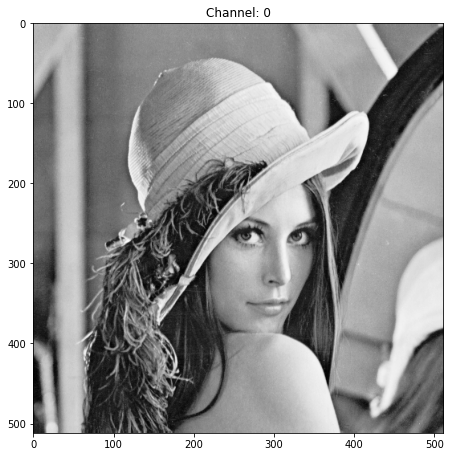

In [192]:
show_image(lenna_image,True)

In [193]:
def show_histogram(input_array, plotColor = 'green' ,num_bins = 255, titlePlot = 'ColorMap', yLabel = 'Freq', xLabel='Intensity') :
   
     input_array = input_array.reshape( (-1,1))
     n, bins, patches = plt.hist(input_array, num_bins, cumulative=False,
                              density = False, 
                              color = plotColor,
                              alpha = 0.7)
     plt.xlabel(xLabel)
     plt.ylabel(yLabel)

     plt.title(titlePlot, fontweight ="bold")

Histogram for Gray Level freq distribution

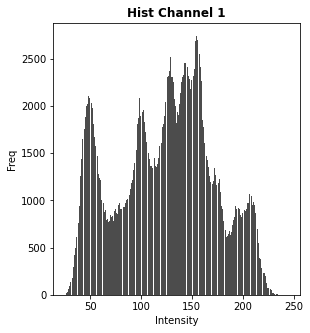

In [194]:
show_image_histogram(lenna_image)

Equalized Histogram for dark image

In [195]:
# assumes gray scale image as input
def equalized_image(input_image: ndarray):
    histogram_array = np.bincount(input_image.flatten(), minlength=256)
    #normalized histogram
    total_pixels = np.sum(histogram_array)
    histogram_array = histogram_array/total_pixels

    #cumulative histogram
    chistogram_array = np.cumsum(histogram_array)

    # (L-1)*cdf
    transform_map = np.floor(255 * chistogram_array).astype(np.uint8)

    # collect pixels of input image and transform values to equalize
    image_pixels = list(input_image.flatten())
    matched_pixels = [transform_map[p] for p in image_pixels]

    # reshape
    transformed_image = np.reshape(np.asarray(matched_pixels), input_image.shape)
    return transformed_image

def display_dark_image_and_histogram(dark_image):
    dark_copy = np.copy(dark_image)

    show_image(dark_copy,True)
    show_image_histogram(dark_copy, True)

    transformed_dark_image = equalized_image(dark_copy)

    show_image(transformed_dark_image,True)
    show_image_histogram(transformed_dark_image, True)


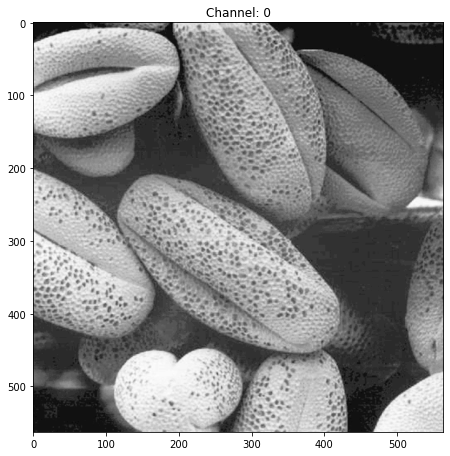

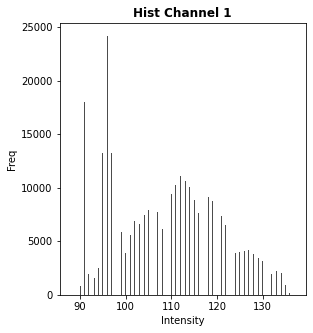

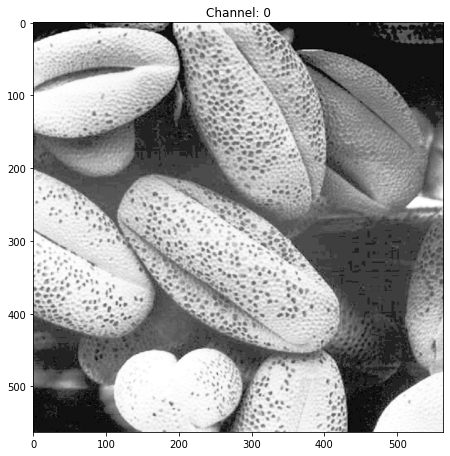

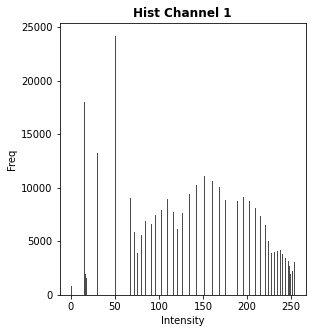

In [196]:
dark_image = read_image_as_numpy_array("dark_image.png")
display_dark_image_and_histogram(dark_image)

Inverted Image Plot

In [197]:
def invert_image(image_2d_array):
    inverted_image = 255 - image_2d_array
    return inverted_image

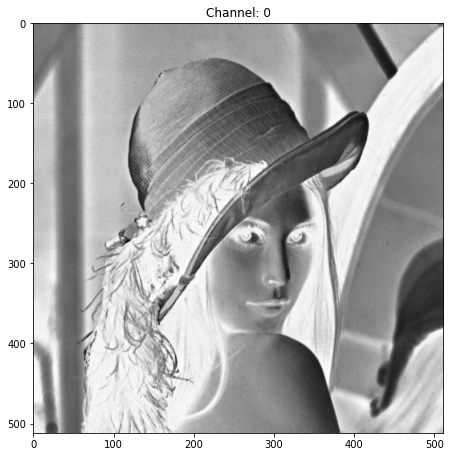

In [198]:
lenna_image_inverted = invert_image(lenna_image)
show_image(lenna_image_inverted)

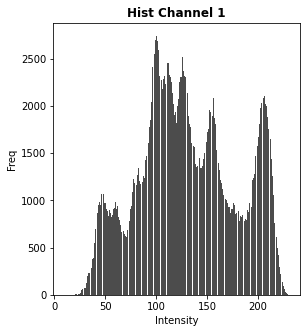

In [199]:
show_image_histogram(lenna_image_inverted)

(512, 512)


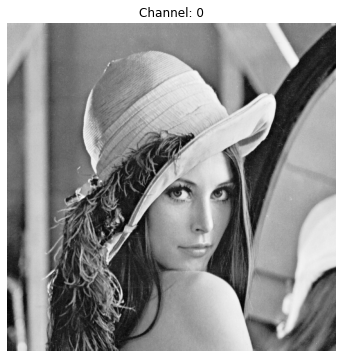

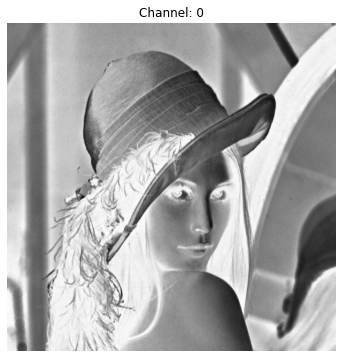

In [200]:
from typing import Callable
from functools import partial
from numpy import ndarray

def execute_custom_operation( input_lambda, subplot_row=1, subplot_column =3, grey_only = True):
    plt.figure( figsize=(20,10) )

    for i in range(1 if grey_only else 3):
        plt.subplot( subplot_row, subplot_column, i+1)
        input_lambda(i)

def figure_channel_wrapper(index, lambda_to_execute):
    plt.title(f"Channel: {index}")
    lambda_to_execute(index)
    plt.axis("off")

def plot_channel(channels: ndarray, index: int,grey_only = True):
    channel_copy = np.array(channels, copy=True)

    figure_channel_wrapper( index, lambda x:
                plt.imshow(channel_copy[:,:] if grey_only else channel_copy[:,:,index],cmap='Greys_r')
            )

def plot_inverted_channel(channels: ndarray, index: int,grey_only = True) -> None:
    channel_copy = np.array(channels, copy=True)

    def invert_and_show(index):
        inverted_data = invert_image(channel_copy[:,:] if grey_only else channel_copy[:,:,index])
        print(inverted_data.shape)
        plt.imshow(inverted_data, cmap='Greys_r')

    figure_channel_wrapper( index, (lambda x: 
                invert_and_show(x)
            )
        )

channel_plot = partial(plot_channel, channels = lenna_image)
channel_inverted_plot = partial(plot_inverted_channel, channels = lenna_image)

execute_custom_operation( lambda x: channel_plot(index=x), subplot_row=1 )
execute_custom_operation( lambda x: channel_inverted_plot(index=x), subplot_row=1 )

Spatial Filter(Linear + Non Linear)

In [201]:
# assume 3x3 filter
import numpy as np
def manipulate(image_array, x_index, y_index, execute):
    a = image_array
    i,j = x_index, y_index

    input_array = [ a[i-1, j-1] , a[i, j-1] , a[i+1,j-1]
             , a[i-1, j] , a[i, j] , a[i+1,j]
            , a[i-1, j+1] , a[i, j+1] , a[i+1,j+1]
            ]

    return execute(input_array)

    # return int(np.sum(input_array)/len(input_array))

    # result: np.int16 = (a[i-1, j-1] + a[i, j-1] + a[i+1,j-1]
    #          + a[i-1, j] + a[i, j] + a[i+1,j]
    #         + a[i-1, j+1] + a[i, j+1] + a[i+1,j+1]
    #         )
    # return int(result/9)

def max_pixel(image_array, x_index, y_index):
    operation = lambda arr :  np.max(arr)#np.amin(arr)
    return manipulate(image_array, x_index, y_index,operation)

def min_pixel(image_array, x_index, y_index):
    operation = lambda arr :  np.min(arr)#np.amin(arr)
    return manipulate(image_array, x_index, y_index,operation)

def median_pixel(image_array, x_index, y_index):
    operation = lambda arr :  np.median(arr)#np.amin(arr)
    return manipulate(image_array, x_index, y_index,operation)

def avg_pixel(image_array, x_index, y_index):
    averager = lambda arr : int(sum(arr)/len(arr))
    return manipulate(image_array, x_index, y_index,averager)

def filter_out(image_array, filter_operation):
    width,height = image_array.shape
    
    for i in range(1,width-1):
        for j in range(1,height-1):
            image_array[i,j] = filter_operation(image_array, i, j)

In [202]:
import time
import os
def plot_with_filter(channels: ndarray, index: int,filter_opeartor, should_invert_image:bool = False, grey_only = True) -> None:
    channel_copy = np.array(channels, copy=True)
    def invert_filter_and_show(index):
        if should_invert_image:
            inverted_data = invert_image(channel_copy[:,:] if grey_only else channel_copy[:,:,index])
        else:
            inverted_data = channel_copy[:,:] if grey_only else channel_copy[:,:,index]
        filter_out(inverted_data, filter_opeartor)
        plt.imshow(inverted_data, cmap='Greys_r')

        #plt.imsave( f"{time.time()}.jpg", inverted_data)

    figure_channel_wrapper( index, (lambda x: 
                invert_filter_and_show(x)
            )
        )


Max Filter on Inverted

In [203]:
inverted_filter = partial(plot_with_filter, channels = lenna_image,should_invert_image=True)




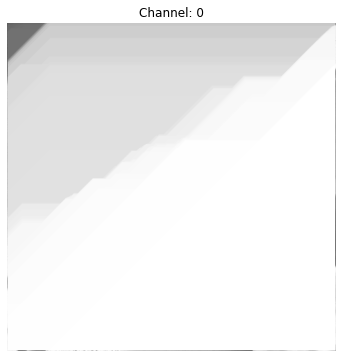

In [204]:
execute_custom_operation( lambda x: inverted_filter(index=x,filter_opeartor=max_pixel), subplot_row=1 )


Min Filter on Inverted



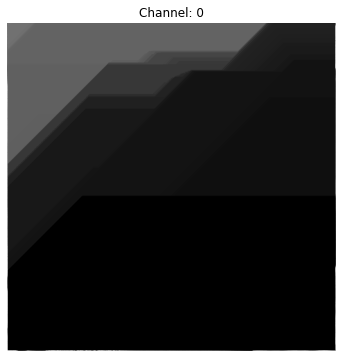

In [205]:
execute_custom_operation( lambda x: inverted_filter(index=x,filter_opeartor=min_pixel), subplot_row=1 )


Median Filter on Inverted Image

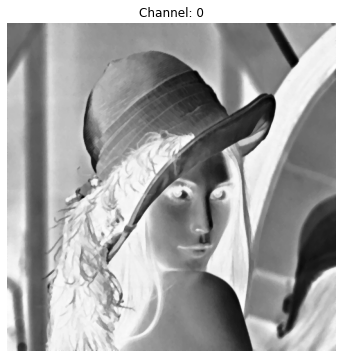

In [206]:
execute_custom_operation( lambda x: inverted_filter(index=x,filter_opeartor=median_pixel), subplot_row=1 )


Avg Filter on Inverted Image

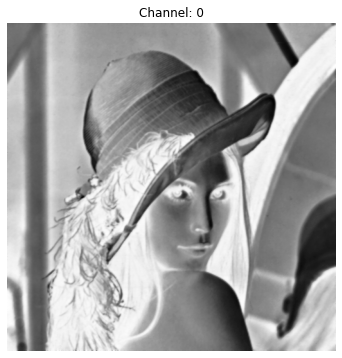

In [207]:
execute_custom_operation( lambda x: inverted_filter(index=x,filter_opeartor=avg_pixel), subplot_row=1 )


In [208]:
# array1 = np.array([ [5,3,4, 5, 2], [15,3,4, 25, 2], [5,3,4, 255, 2], [15,73,4, 5, 21]  ] )
# array1.shape

# dummy1 = np.array( [ [10,20, 30], [5,5,100], [60,50, 30] ])
# dummy1 = array1
# filter1 = np.array( [ [0,-1, 0], [-1,4,1], [0,-1, 0] ])
# filter1 = np.array( [ [1,1, 1], [1,1,1], [1,1, 1] ])
# filter1.shape, dummy1.shape

In [209]:
#dummy1 * filter1, np.sum(dummy1*filter1)

In [210]:
# image_size = dummy1.shape 
# filter_size = filter1.shape

In [211]:
# image_size, filter_size

In [212]:
# #dummy1.reshape(-1,1), filter1.reshape(-1,1)
# print(dummy1)
# print("*********")
# dummy1[3, 1::1]

In [213]:
# print(dummy1.strides)
# dummy1[0:3, 2:4:1]

In [214]:
# filter1.shape

In [222]:
from typing import Callable
FilterCallback = Callable[ [ndarray, ndarray, int], int ]

def convolution(input: ndarray, filter: ndarray, callback: FilterCallback ):
    height, width = input.shape
    filter_height, filter_width = filter.shape
    # pad zero to input array
    stack = np.hstack( [np.zeros( (height,1),dtype=int ) , np.copy(input), np.zeros( (height,1),dtype=int )]  )
    stack2 = np.vstack( [ np.zeros( (1, width + 2),dtype=int ) ,stack, np.zeros( (1, width + 2), dtype=int )])

    buffer = np.zeros( shape=(height, width),dtype=int )

    for h in range(0,height):
        for w in range(0, width): 
            snap = stack2[h: h + filter_height, w: w + filter_width]
            result = callback(snap, filter, input[h,w])
            buffer[h,w] = result
    return buffer

def pointwise_multiply_and_add(x: ndarray, y: ndarray, current: int):
    r =  int((np.sum(x*y)))
    return 255 if r >= 255 else current

def pointwise_multiply_and_add_binarization(x: ndarray, y: ndarray, current: int):
    r =  int((np.sum(x*y)))
    return 255 if r >= 20 else 0

def pointwise_multiply_and_average(x: ndarray, y: ndarray, current: int):
    r =  int( (np.sum(x*y))/ (y.shape[0] * y.shape[1]) )
    return 255 if r >= 255 else current



Weighted Average Filter

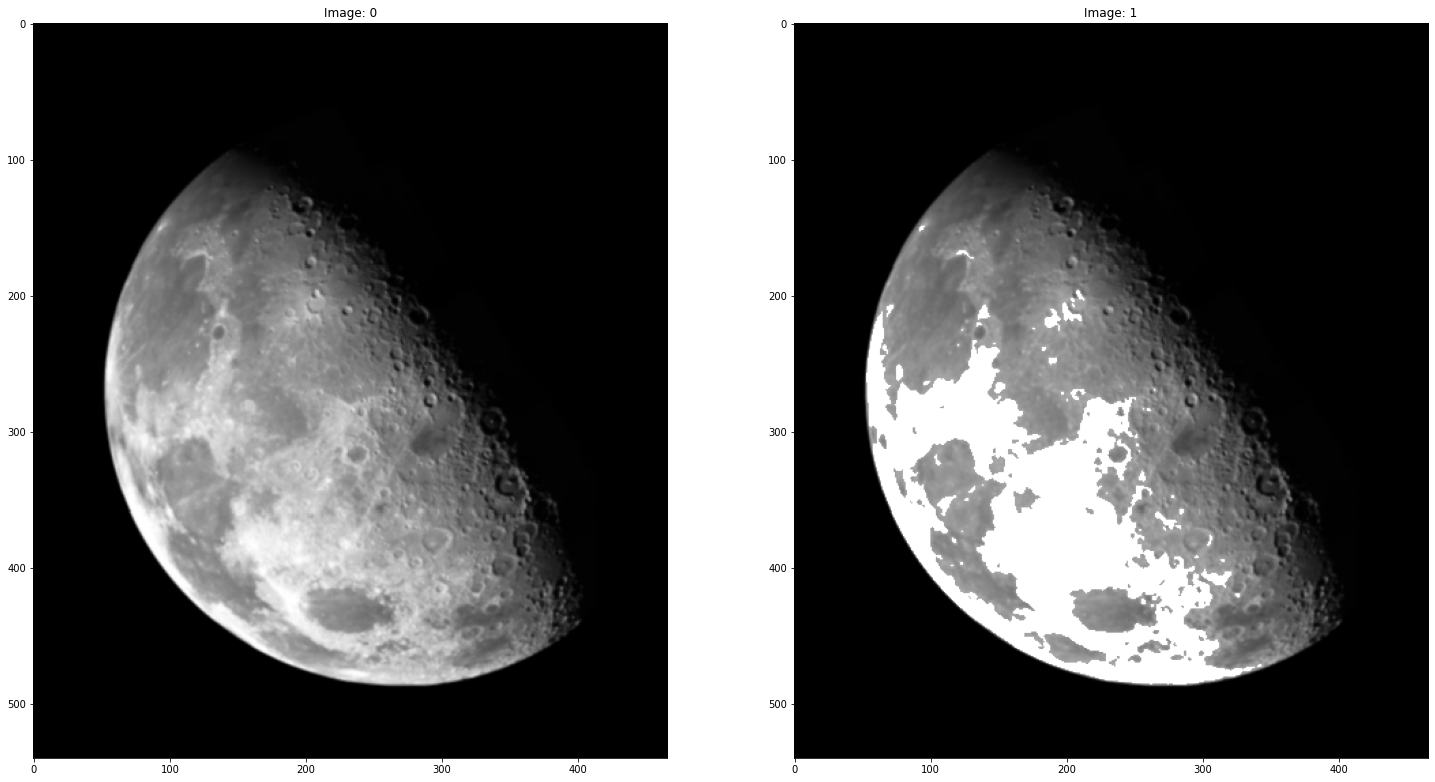

In [216]:
dark_image = read_image_as_numpy_array("blurry_moon.tif",True)
copied_array = np.copy(dark_image[:,:])
weighted_avg_filter = np.array( 
[ 
    [1, 2, 1], 
    [2, 4, 2], 
    [1, 2, 1] 
] )

#show_image(copied_array,True)


conv_result = convolution(copied_array, weighted_avg_filter, pointwise_multiply_and_average)

show_image_side_by_side([copied_array, conv_result])

#show_image_histogram(copied_array, True)
#show_image_histogram(conv_result, True)


Laplacian Enhanced

In [217]:
blurry_moon = read_image_as_numpy_array("blurry_moon.tif",True)

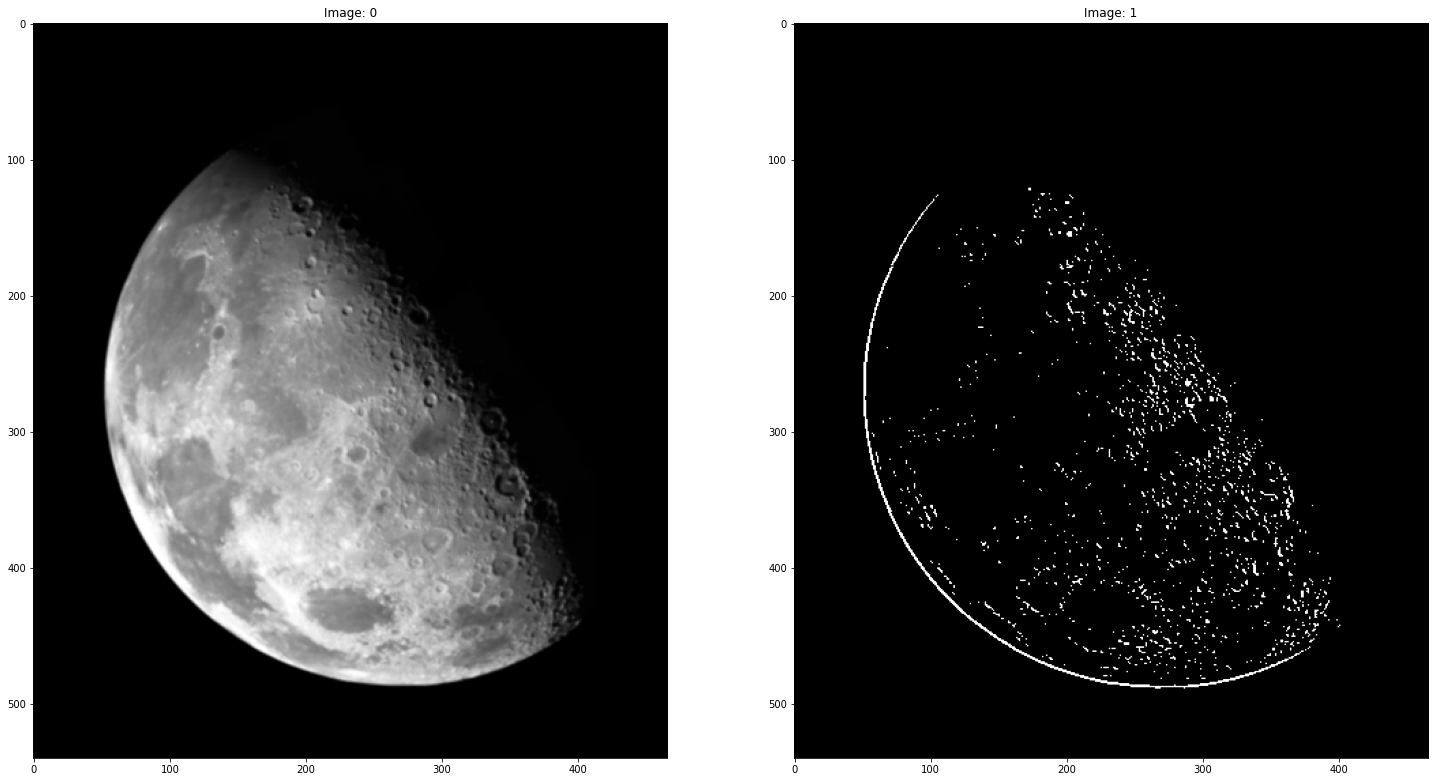

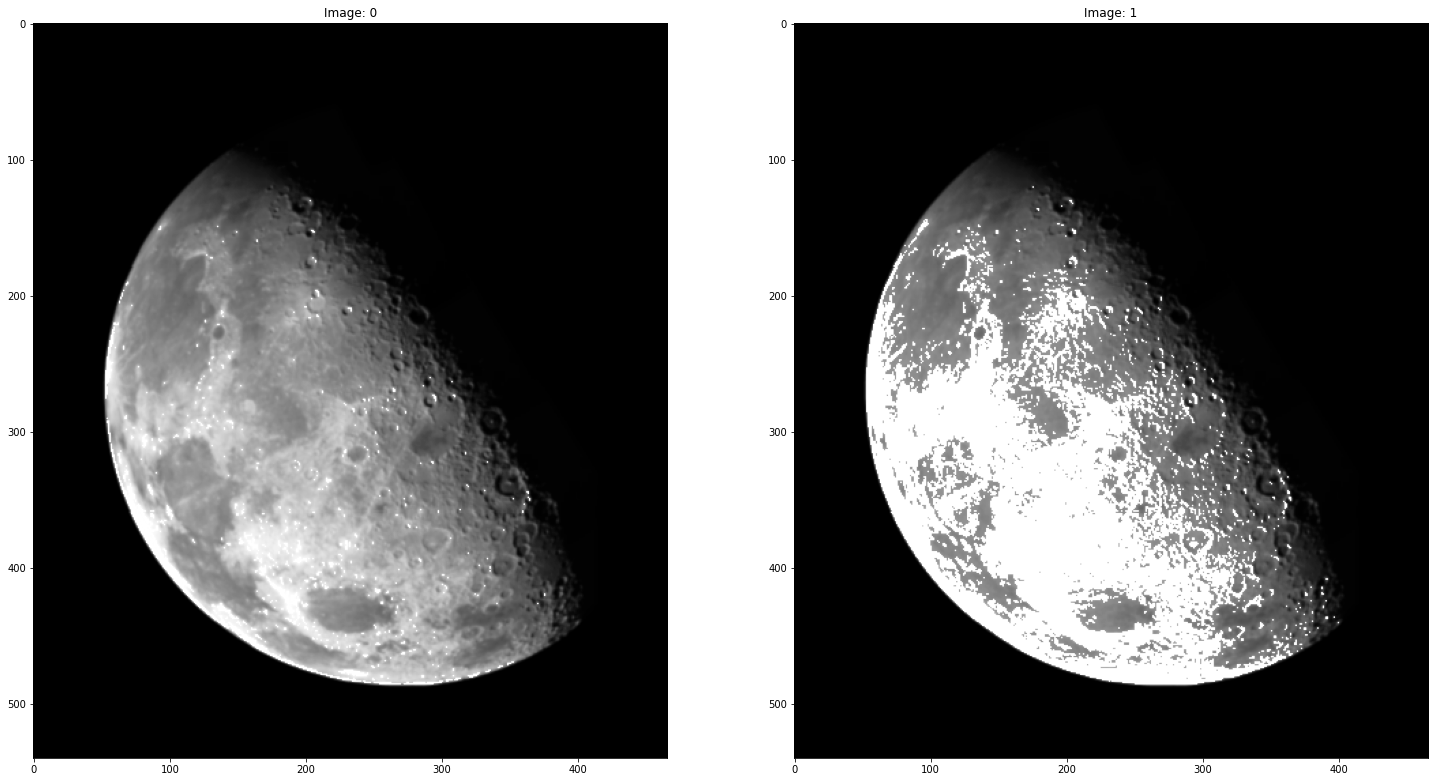

In [218]:
copy_moon = np.copy(blurry_moon)
#show_image(copy_moon, True)

lap_filter = np.array( 
[ 
    [0, 1, 0], 
    [1, -4, 1], 
    [0, 1, 0] 
] )
conv_result = convolution(copy_moon, lap_filter, pointwise_multiply_and_add_binarization)

show_image_side_by_side([copy_moon, conv_result])

enhanced_laplacian_filter = np.array( 
[ 
    [-1, -1, -1], 
    [-1, 9, -1], 
    [-1, -1, -1] 
] )

over_laplacian_filter = np.array( 
[ 
    [-1, -1, -1], 
    [-1, 10, -1], 
    [-1, -1, -1] 
] )

copy_moon = np.copy(blurry_moon)

conv_result2 = convolution(copy_moon, enhanced_laplacian_filter, pointwise_multiply_and_add)

copy_moon = np.copy(blurry_moon)
conv_result3 = convolution(copy_moon, over_laplacian_filter, pointwise_multiply_and_add)

show_image_side_by_side([conv_result2, conv_result3])



Sobel


In [240]:
def sobel(input_array: ndarray, horizontal = True):
    sobel_filter = np.array( 
            [ 
                [-1, -2, -1], 
                [0, 0, 0], 
                [1, 2, 1] 
            ] )

    if horizontal == False:
        sobel_filter = np.array( 
            [ 
                [-1, 0, 1], 
                [-2, 0, 2], 
                [-1, 0, 1] 
            ] )


    def sobel_operation(x: ndarray, y: ndarray, current: int):
        r =  int((np.sum(x*y)))
        return 255 if r >= 50 else 0

    return convolution(input_array, sobel_filter, sobel_operation)

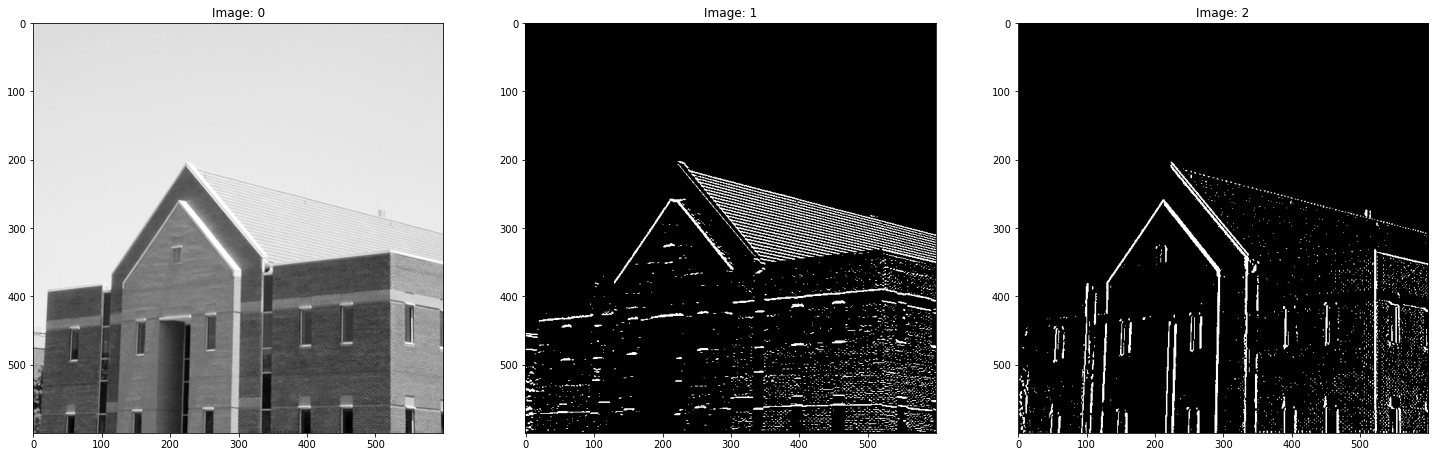

In [241]:
home = read_image_as_numpy_array("home.tif",True)
copy_home = np.copy(home)
#show_image(copy_moon, True)

conv1 = sobel(copy_home)

conv2 = sobel(copy_home,horizontal=False)

show_image_side_by_side([copy_home, conv1,conv2])

